In [164]:
%matplotlib notebook

In [165]:
import numpy as np
from matplotlib import pyplot
import astropy.constants
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

In [166]:
class Particle(object):
    def __init__(self, initial_position, initial_velocity, mass, number_time_steps):
        self.position = np.zeros((number_time_steps, 3))
        self.position[0] = initial_position
        self.velocity =  np.zeros((number_time_steps, 3))
        self.velocity[0] = initial_velocity
        self.acceleration = np.zeros((number_time_steps, 3))
        self.mass = mass
        self.pvec = np.zeros((number_time_steps, 3))
        self.pvec[0] = mass * np.cross(initial_position, initial_velocity)
        self.pmag = np.zeros((number_time_steps, 1))
        self.pmag[0] = magnitude(mass * np.cross(initial_position, initial_velocity))
        self.emag = np.zeros((number_time_steps, 1))
        self.speed = np.zeros((number_time_steps, 1))
        self.speed[0] = magnitude(initial_velocity)
        
    def update_position(self, t):
        self.position[t] = self.position[t - 1]
        self.position[t] += self.velocity[t - 1] * delta_t
        self.position[t] += 0.5 * self.acceleration[t - 1] * delta_t * delta_t
    
    def update_velocity(self, t):
        self.velocity[t] = self.velocity[t - 1]
        self.velocity[t] += 0.5 * delta_t * (self.acceleration[t] + self.acceleration[t - 1])
    
    def update_acceleration(self, t, particles):
        for particle in particles:
            if particle != self:
                r12 = particle.vector_to(self.position, t)
                self.acceleration[t] += G * np.asarray(particle.mass) * r12 / magnitude(r12) ** 3.0
        
    def vector_to(self, position1, t):
        return self.position[t] - position1[t]
    
    def p_vector(self, t):
        self.pvec[t] = self.mass * np.cross(self.position[t], self.velocity[t])
        
    def p_magnitude(self, t):
        self.pmag[t] = magnitude(self.pvec[t])
        
    def e_magnitude(self, t, particles):
        for particle in particles:
            if particle != self:
                r12 = particle.vector_to(self.position, t)
                self.emag[t] = 0.5 * self.mass * np.dot(self.velocity[t], self.velocity[t]) -G * self.mass * np.asarray(particle.mass) / magnitude(r12)
                
    def update_speed(self, t):
        self.speed[t] = magnitude(self.velocity[t])

In [167]:
def magnitude(vector):
    return np.sqrt(vector[0] ** 2.0 + vector[1] ** 2.0 + vector[2] ** 2.0)

In [215]:
number_of_time_steps = 100
delta_t = 1.0
G = astropy.constants.G.to('AU**3 / (day**2 * earthMass)').value
sun_mass = 333000

In [245]:
#Kepler 16-A primary star values
Kep16A_m = 0.6897 * sun_mass
Kep16A_a = 0.04945
Kep16A_e = 0.15944
Kep16A_b = Kep16A_a * (1 - Kep16A_e ** 2) ** (1/2)
Kep16A_theta  = 0

#Kepler 16-A position
Kep16A_x = - Kep16A_a * Kep16A_e + Kep16A_a * np.cos(Kep16A_theta)
Kep16A_y = Kep16A_b * np.sin(Kep16A_theta)
Kep16A_z = 0
Kep16A_V = [Kep16A_x, Kep16A_y, Kep16A_z]

#Kepler 16-B red dwarf values
Kep16B_m = 0.20255 * sun_mass
Kep16B_a = 0.1705 
Kep16B_e = 0.15944
Kep16B_b = Kep16B_a * (1 - Kep16B_e ** 2) ** (1/2)
Kep16B_theta = np.pi

#Kepler 16-B position
Kep16B_x = - Kep16B_a * Kep16B_e + Kep16B_a * np.cos(Kep16B_theta)
Kep16B_y = Kep16B_b * np.sin(Kep16B_theta)
Kep16B_z = 0
Kep16B_V = [Kep16B_x, Kep16B_y, Kep16B_z]

#Kepler 16-AB reduced mass
Kep16AB_reducedmass = ( Kep16A_m * Kep16B_m ) / ( Kep16A_m + Kep16B_m )

#Kepler 16-A velocity
Kep16A_thetadot = np.pi * 2 / 40
#np.sqrt(Kep16A_a * ( 1 - Kep16A_e ** 2) * G * Kep16A_m * Kep16B_m * Kep16AB_reducedmass) * (1 + Kep16A_e * np.cos(Kep16A_theta)) ** 2 / (Kep16AB_reducedmass * (Kep16A_a * Kep16B_e) ** 2)
Kep16A_xdot = - Kep16A_a * np.sin(Kep16A_theta) * Kep16A_thetadot
Kep16A_ydot = Kep16A_b * np.cos(Kep16A_theta) * Kep16A_thetadot
Kep16A_zdot = 0
Kep16A_Vdot = [Kep16A_xdot, Kep16A_ydot, Kep16A_zdot]


Kep16B_Rz = np.array([[np.cos(np.deg2rad(180)), -np.sin(np.deg2rad(180)), 0], [np.sin(np.deg2rad(180)), np.cos(np.deg2rad(180)), 0], [0, 0, 1]])
Kep16B_Ry = np.array([[np.cos(np.deg2rad(0)), 0, np.sin(np.deg2rad(0))], [0, 1, 0], [-np.sin(np.deg2rad(0)), 0, np.cos(np.deg2rad(0))]])
Kep16B_both = np.matmul(Kep16B_Rz, Kep16B_Ry)


#Kepler 16-B velocity
Kep16B_thetadot = np.pi * 2 / 40
#np.sqrt(Kep16B_a * ( 1 - Kep16B_e ** 2) * G * Kep16A_m * Kep16B_m * Kep16AB_reducedmass) * (1 + Kep16B_e * np.cos(Kep16B_theta)) ** 2 / (Kep16AB_reducedmass * (Kep16B_a * Kep16B_e) ** 2)
Kep16B_xdot = - Kep16B_a * np.sin(Kep16B_theta) * Kep16B_thetadot
Kep16B_ydot = Kep16B_b * np.cos(Kep16B_theta) * Kep16B_thetadot
Kep16B_zdot = 0
Kep16B_Xdot = [Kep16B_xdot, Kep16B_ydot, Kep16B_zdot]
Kep16B_Vdot = np.matmul(Kep16B_both, Kep16B_Xdot)


In [246]:
Kep16A_V, Kep16B_V

([0.041565692, 0.0, 0], [-0.19768452, 2.061312013030618e-17, 0])

In [247]:
Kep16A_thetadot, Kep16B_thetadot

(0.15707963267948966, 0.15707963267948966)

In [248]:
Kep16AB_reducedmass

52137.493701316904

In [249]:
Kep16A_Vdot, Kep16B_Vdot

([-0.0, 0.007668221906281857, 0],
 array([6.51775987e-18, 2.64394709e-02, 0.00000000e+00]))

In [250]:
np.sqrt(Kep16AB_reducedmass * G / Kep16A_a)

0.030611627273490004

In [251]:
Kep16B_Rz

array([[-1.0000000e+00, -1.2246468e-16,  0.0000000e+00],
       [ 1.2246468e-16, -1.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [252]:
Kep16A = Particle(Kep16A_V, Kep16A_Vdot, Kep16A_m, number_of_time_steps)
Kep16B = Particle(Kep16B_V, Kep16B_Xdot, Kep16B_m, number_of_time_steps)

In [253]:
particles = [Kep16A, Kep16B]

In [254]:
for particle in particles:
    particle.update_acceleration(0, particles)
    particle.e_magnitude(0, particles)

In [255]:
for t in np.arange(1, number_of_time_steps):
    for particle in particles:
        particle.update_position(t)
    for particle in particles:
        particle.update_acceleration(t, particles)
    for particle in particles:
        particle.update_velocity(t)
    for particle in particles:
        particle.p_vector(t)
    for particle in particles:
        particle.p_magnitude(t)
    for particle in particles:
        particle.e_magnitude(t, particles)

<IPython.core.display.Javascript object>


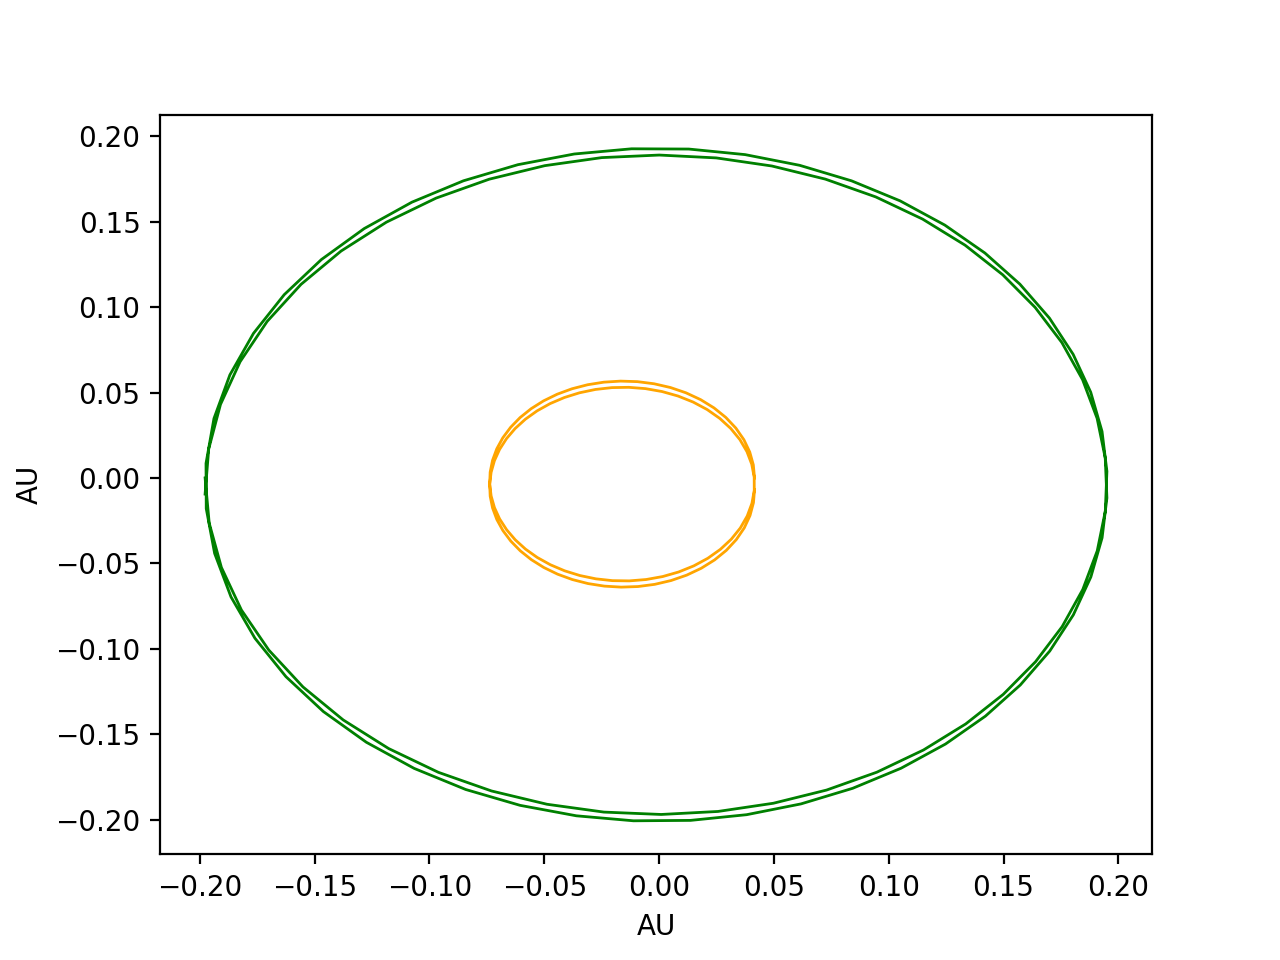

Text(0,0.5,'AU')

In [257]:
pyplot.plot(Kep16A.position[:, 0], Kep16A.position[:, 1], linewidth = 1, color = 'orange')
pyplot.plot(Kep16B.position[:, 0], Kep16B.position[:, 1], linewidth = 1, color = 'green')

pyplot.xlabel("AU")
pyplot.ylabel("AU")

In [262]:
#Kepler 16-b extrasolar planet values
Kep16b_m = 0.333 * 318
Kep16b_a = 0.7048
Kep16b_e = 0.0069
Kep16b_b = Kep16b_a * (1 - Kep16b_e ** 2) ** (1/2)
Kep16b_theta  = 0 

#rotation matrices
Kep16b_Ry = np.array([[np.cos(np.deg2rad(0.0322)), 0, np.sin(np.deg2rad(0.0322))], [0, 1, 0], [-np.sin(np.deg2rad(0.0322)), 0, np.cos(np.deg2rad(0.0322))]])
Kep16b_Rz = np.array([[np.cos(np.deg2rad(55)), -np.sin(np.deg2rad(55)), 0], [np.sin(np.deg2rad(55)), np.cos(np.deg2rad(55)), 0], [0, 0, 1]])
Kep16b_both = np.matmul(Kep16b_Rz, Kep16b_Ry)

#Kepler 16-b position
Kep16b_x = - Kep16b_a * Kep16b_e + Kep16b_a * np.cos(Kep16b_theta)
Kep16b_y = Kep16b_b * np.sin(Kep16b_theta)
Kep16b_z = 0
Kep16b_X = [Kep16b_x, Kep16b_y, Kep16b_z]
Kep16b_V = np.matmul(Kep16b_both, Kep16b_X)

#Kepler 16-b velocity
Kep16ABb_reducedmass = (Kep16b_m * (Kep16A_m + Kep16B_m)) / (Kep16b_m + (Kep16A_m + Kep16B_m))
Kep16b_thetadot = np.pi * 2 / 229
#(Kep16b_a * ( 1 - Kep16b_e ** 2) * G * Kep16b_m * (Kep16A_m + Kep16B_m) * Kep16ABb_reducedmass) ** (1 / 2) * (1 + Kep16b_e * np.cos(Kep16b_theta)) ** 2 / (Kep16ABb_reducedmass * (Kep16b_a * Kep16b_e) ** 2)
Kep16b_xdot = - Kep16b_a * np.sin(Kep16b_theta) * Kep16b_thetadot
Kep16b_ydot = Kep16b_b * np.cos(Kep16b_theta) * Kep16b_thetadot
Kep16b_zdot = 0
Kep16b_Xdot = [Kep16b_xdot, Kep16b_ydot, Kep16b_zdot]
Kep16b_Vdot = np.matmul(Kep16b_both, Kep16b_Xdot)

In [263]:
Kep16b = Particle(Kep16b_V, Kep16b_Vdot, Kep16b_m, number_of_time_steps)

In [264]:
particles = [Kep16A, Kep16B, Kep16b]

<IPython.core.display.Javascript object>


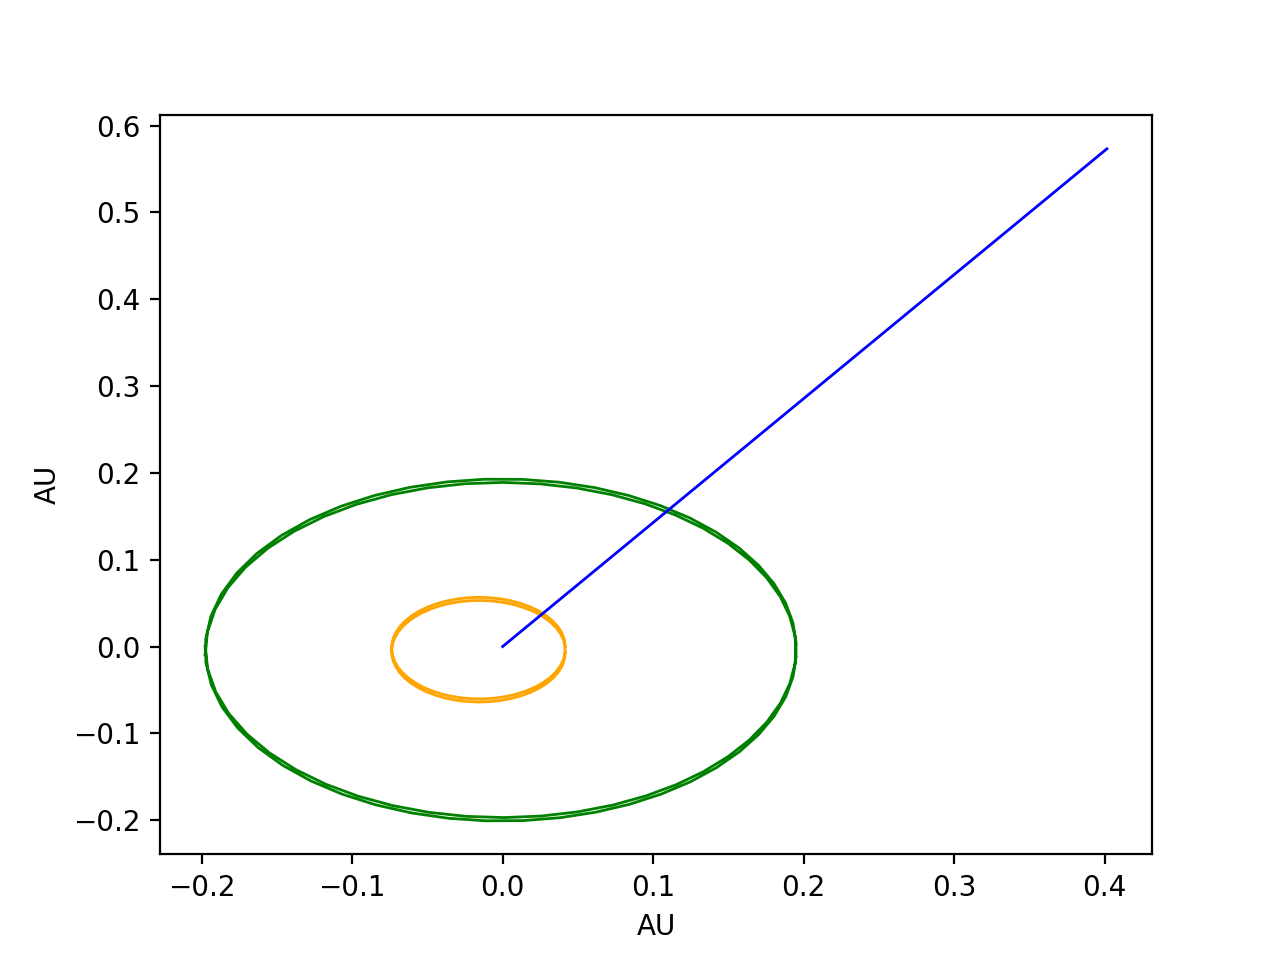

Text(0,0.5,'AU')

In [267]:
pyplot.plot(Kep16A.position[:, 0], Kep16A.position[:, 1], linewidth = 1, color = 'orange')
pyplot.plot(Kep16B.position[:, 0], Kep16B.position[:, 1], linewidth = 1, color = 'green')
pyplot.plot(Kep16b.position[:, 0], Kep16b.position[:, 1], linewidth = 1, color = 'blue')

pyplot.xlabel("AU")
pyplot.ylabel("AU")

<IPython.core.display.Javascript object>


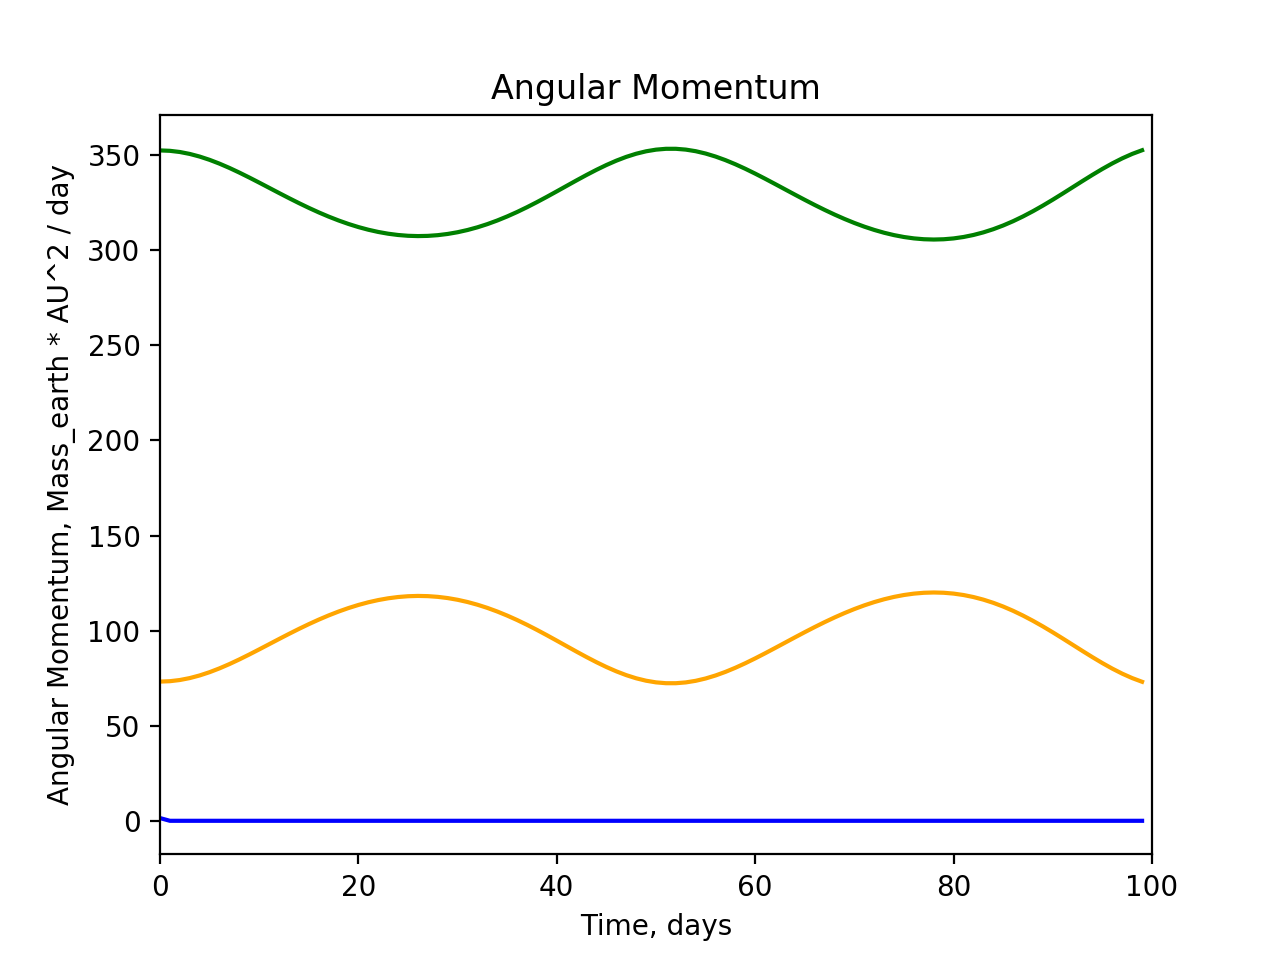

Text(0,0.5,'Angular Momentum, Mass_earth * AU^2 / day')

In [268]:
pyplot.plot(np.arange(0, number_of_time_steps, 1), Kep16A.pmag, color='orange')
pyplot.plot(np.arange(0, number_of_time_steps, 1), Kep16B.pmag, color='green')
pyplot.plot(np.arange(0, number_of_time_steps, 1), Kep16b.pmag, color='blue')

pyplot.xlim(0, number_of_time_steps)
pyplot.title("Angular Momentum")
pyplot.xlabel("Time, days")
pyplot.ylabel("Angular Momentum, Mass_earth * AU^2 / day")

<IPython.core.display.Javascript object>


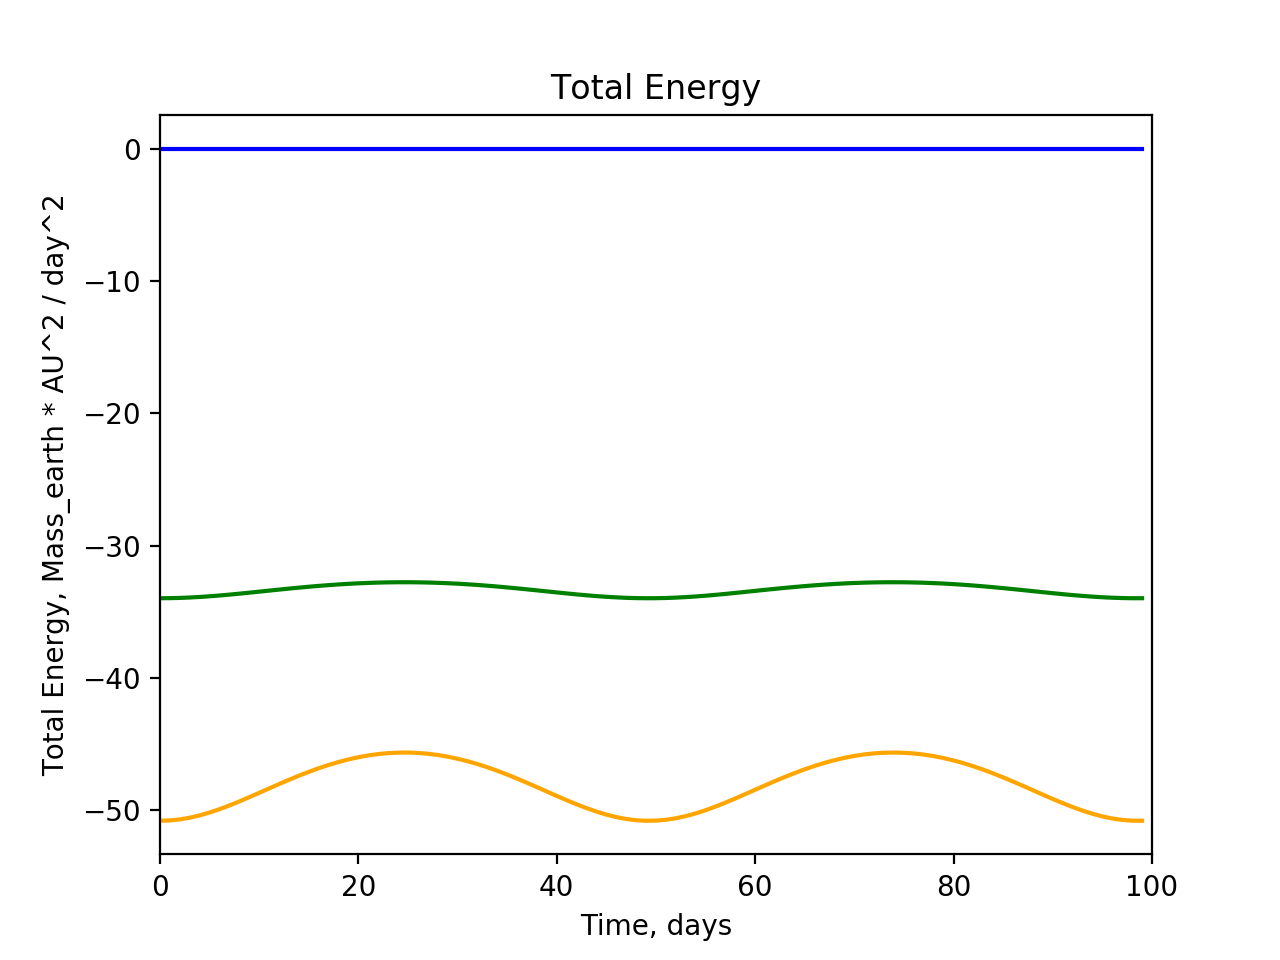

Text(0,0.5,'Total Energy, Mass_earth * AU^2 / day^2')

In [269]:
pyplot.plot(np.arange(0, number_of_time_steps, 1), Kep16A.emag, color='orange')
pyplot.plot(np.arange(0, number_of_time_steps, 1), Kep16B.emag, color='green')
pyplot.plot(np.arange(0, number_of_time_steps, 1), Kep16b.emag, color='blue')

pyplot.xlim(0, number_of_time_steps)
pyplot.title("Total Energy")
pyplot.xlabel("Time, days")
pyplot.ylabel("Total Energy, Mass_earth * AU^2 / day^2")